In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import NestedSampler
from scipy.stats import norm
from dynesty import plotting as dyplot
from dynesty.utils import quantile
import pandas as pd
from scipy.stats import poisson
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u


In [2]:
def prior_transform(u):
    
    lambda_min, lambda_max = 0, 300  
    return [lambda_min + u[0] * (lambda_max - lambda_min)]

def log_likelihood(theta):
    
    lambda_ = theta[0]  
#     if lambda_ <= 0:  # Ensure λ is positive
#         return -np.inf
    return np.sum(poisson.logpmf(y, mu=lambda_))

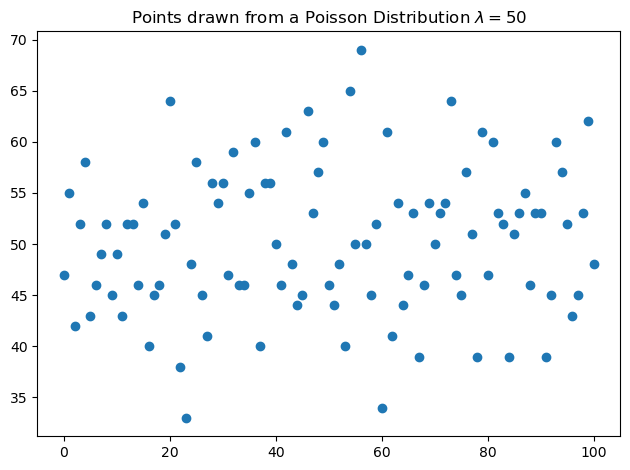

In [3]:
np.random.seed(42)

x = np.linspace(0,100,101)
lambda_true = 50
y = np.random.poisson(lambda_true, size=len(x))
plt.scatter(x,y)
plt.title(r'Points drawn from a Poisson Distribution $\lambda = {:s}$'.format(str(lambda_true)))
plt.tight_layout()
# plt.savefig('../Figures/poisson_distribution_lambda={:s}.png'.format(str(lambda_true)), dpi=300 )
plt.show()

5463it [00:14, 380.03it/s, +1000 | bound: 3 | nc: 1 | ncall: 39418 | eff(%): 16.823 | loglstar:   -inf < -341.923 <    inf | logz: -346.999 +/-  0.051 | dlogz:  0.001 >  1.009]


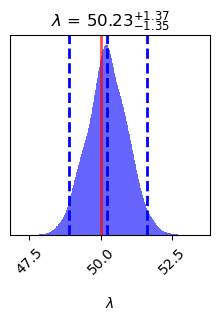

In [4]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=1, nlive=1000)


sampler.run_nested()
results = sampler.results

fig, ax = dyplot.cornerplot(results, color='blue', truths=[lambda_true],
                           truth_color='red', show_titles=True,
                           max_n_ticks=3, labels=[r'$\lambda$'])

# plt.savefig('../Figures/corner_plot_lambda={:s}.png'.format(str(lambda_true)), dpi=300)

# Now what if lambda_i changes?

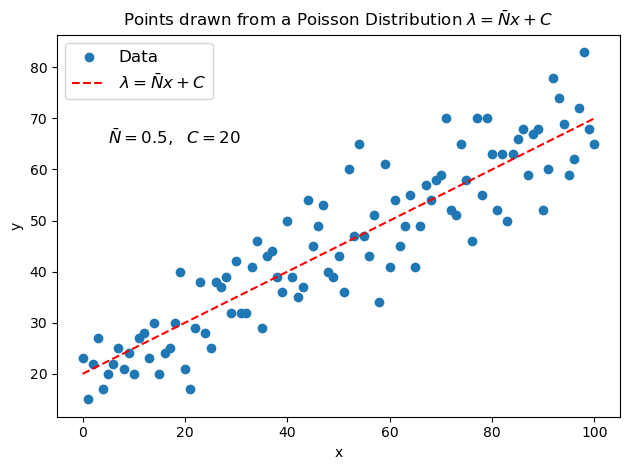

In [5]:
np.random.seed(42)

x = np.linspace(0, 100, 101)  # Independent variable
N_bar_true = 0.5
C_true = 20

lambda_true = N_bar_true * x + C_true  # Linearly varying Poisson rate
y = np.random.poisson(lambda_true, size=len(x))  # Poisson-distributed data

plt.scatter(x, y, label="Data")
plt.plot(x, lambda_true, color="r", label=r"$\lambda = \bar{N}x + C$", ls='--')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12)

plt.title(r'Points drawn from a Poisson Distribution $\lambda =  \bar{N}x + C$')
plt.annotate(r'$\bar N = {:s},\ \ C = {:s}$'.format(str(N_bar_true), str(C_true)), xy=(5,65), fontsize=12)
plt.tight_layout()
# plt.savefig('../Figures/poisson_distribution_lambda=Nx_+_C.png', dpi=300 )
plt.show()


In [6]:
def prior_transform(u):
    N_bar_min, N_bar_max = 0, 100
    C_min, C_max = 0, 50

    N_bar = N_bar_min + u[0] * (N_bar_max - N_bar_min)
    C = C_min + u[1] * (C_max - C_min)
    return [N_bar, C]


def log_likelihood(theta):
    N_bar, C = theta  
    lambda_i = N_bar * x + C

#     if np.any(lambda_i <= 0):
#         return -np.inf

    return np.sum(poisson.logpmf(y, mu=lambda_i))


11356it [00:18, 622.42it/s, +1000 | bound: 10 | nc: 1 | ncall: 49577 | eff(%): 25.436 | loglstar:   -inf < -333.918 <    inf | logz: -345.041 +/-  0.101 | dlogz:  0.001 >  1.009]


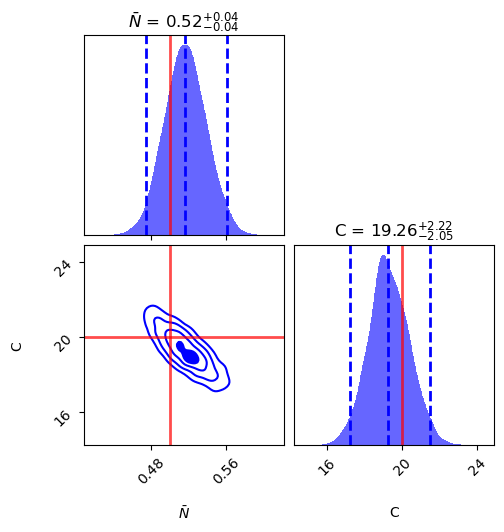

In [7]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=2, nlive=1000)
sampler.run_nested()
results = sampler.results

fig, ax = dyplot.cornerplot(results, color='blue', truths=[N_bar_true, C_true],
                           truth_color='red', show_titles=True,
                           max_n_ticks=3, labels=[r'$\bar N$', 'C'])

# plt.savefig('../Figures/corner_plot_lambda==Nx_+_C.png', dpi=300)

In [20]:
results.logwt

array([-4.82423271e+05, -4.81871019e+05, -4.80883243e+05, ...,
       -3.52178489e+02, -3.52177942e+02, -3.52177326e+02])

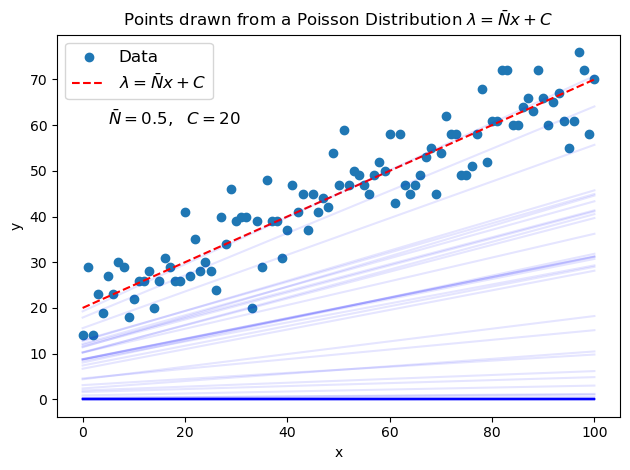

In [47]:
np.random.seed(42)
samples = results['samples']
weights = np.exp(results['logwt'] - np.max(results['logwt']))  # Normalize weights

weighted_samples = samples * weights[:, None]


random_indices = np.random.choice(len(weighted_samples), size=100, replace=False)
plt.figure()

x = np.linspace(0, 100, 101)  # Independent variable
N_bar_true = 0.5
C_true = 20

lambda_true = N_bar_true * x + C_true  # Linearly varying Poisson rate
y = np.random.poisson(lambda_true, size=len(x))  # Poisson-distributed data

plt.scatter(x, y, label="Data")
plt.plot(x, lambda_true, color="r", label=r"$\lambda = \bar{N}x + C$", ls='--')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12)

for i in random_indices:
    vals = weighted_samples[int(i)]
    y_i = vals[0]*x + vals[1]
    plt.plot(x, y_i, alpha=0.1, c='b')

plt.title(r'Points drawn from a Poisson Distribution $\lambda =  \bar{N}x + C$')
plt.annotate(r'$\bar N = {:s},\ \ C = {:s}$'.format(str(N_bar_true), str(C_true)), xy=(5,60), fontsize=12)
plt.tight_layout()

plt.show()
plt.close()

# Now what about for a dipole?

In [48]:
def pixel_angles(pixel_vec, dipole_vec):
    dot_product = np.dot(pixel_vec, dipole_vec)
    theta = np.arccos(dot_product) # don't need the magnitude bc they are unit vectors
    return theta

def poisson_sampling(NSIDE, N_bar, D, dipole_theta, dipole_phi):
    NPIX = hp.nside2npix(NSIDE)
    pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))).T
    dipole_vec = hp.ang2vec(dipole_theta, dipole_phi) # (x, y, z) from (b, l)
    
    theta_angle = pixel_angles(pixel_vec, dipole_vec)
    lambda_ = N_bar * (1 + D*np.cos(theta_angle))
    sample = np.random.poisson(lambda_)
    return sample, lambda_
        
def plotting(m, dipole_theta=None, dipole_phi=None, title=None, unit=None, cmap='viridis'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap);

    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=15);
    plt.tight_layout()
#     plt.show()
#     plt.close()
    return


def omega_to_theta(omega):
    '''Convert solid angle in steradins to theta in radians for
    a cone section of a sphere. Taken from the code used in Secrest (2021),
    namely in CatWISE_Dipole_Resulys.ipynb. '''
    return np.arccos(1 - omega / (2 * np.pi)) * u.rad

def compute_smooth_map(m: np.ndarray, weights=None, angle_scale=1):
        'Smooth the map using a moving average.'
        included_pixels = np.where(~np.isnan(m))[0]
        smoothed_map = np.full(m.shape, np.nan, dtype=float)
        nside = hp.get_nside(m)
        
        if type(weights) != np.ndarray:
            weights = np.ones_like(m).astype('float')

        smoothing_radius = omega_to_theta(angle_scale).value
        for p_index in included_pixels:
            vec = hp.pix2vec(nside, p_index)
            disc = hp.query_disc(nside, vec, smoothing_radius)
            smoothed_map[p_index] = np.nanmean(m[disc].astype(float) * weights[disc].astype(float))

        return smoothed_map

In [134]:
NSIDE=32
NPIX = hp.nside2npix(NSIDE)
N_bar_true = 100
D_true = 0.01 # dipole amplitude, using value from paper

#  dipole vector
dipole_theta = np.pi/4
dipole_phi = np.pi/2
x_dip, y_dip, z_dip = hp.ang2vec(dipole_theta, dipole_phi) 

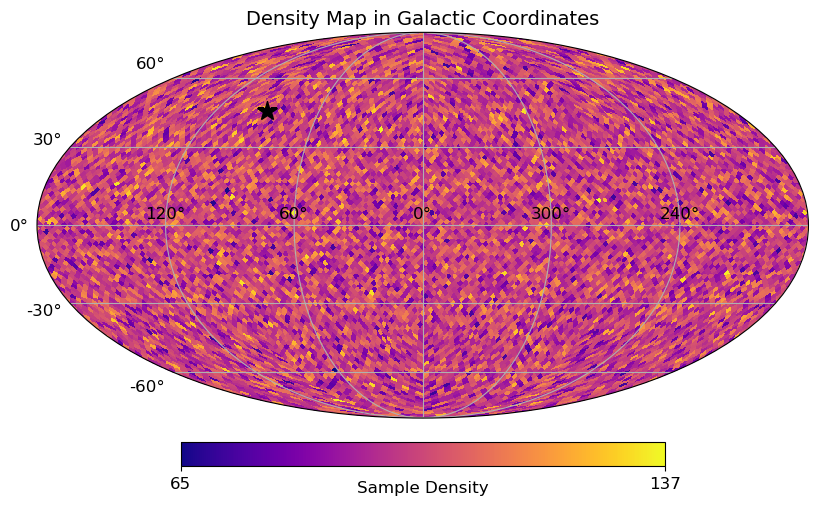

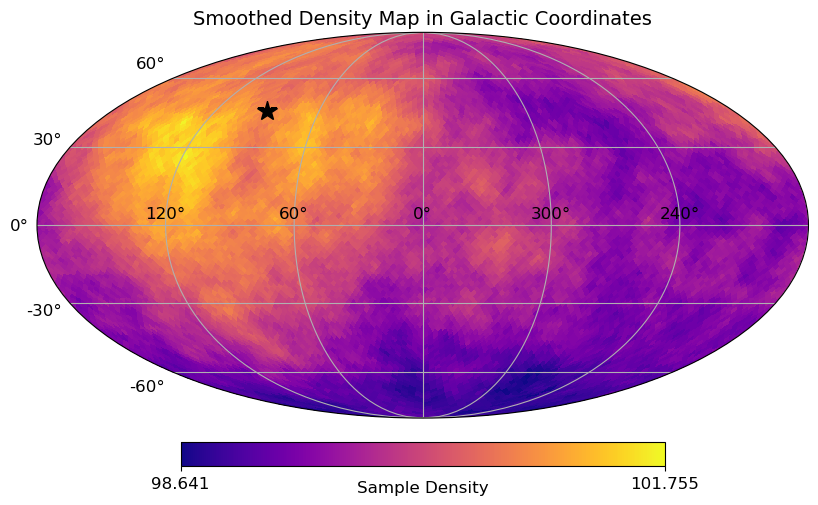

In [135]:
np.random.seed(42)
m, lambda_true_array = poisson_sampling(NSIDE=NSIDE,  N_bar=N_bar_true, D=D_true, dipole_theta=np.pi/4, dipole_phi=np.pi/2)

#Unsmoothed
plotting(m, dipole_theta, dipole_phi,
         title='Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

smoothed_map = compute_smooth_map(m, weights=None, angle_scale=1)

plotting(smoothed_map, dipole_theta, dipole_phi,
         title='Smoothed Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

In [144]:
def prior_transform(u):
    N_bar = u[0]*1000 # 0 - 100
    D = u[1]/10 # 0 - 0.1
    l = u[2]*2*np.pi # 0 - 2pi
    
    c = u[3] # 0 - 1, used to calculate theta below. 
    # Oliver uses 0 - 0.1, but this doesnt return theta between (0,pi), is it a typo or am i missing something else?
    b = np.arccos(np.clip(1 - 2*c, -1, 1)) #Clipping to ensure we stay in the valid range
    
    return  N_bar, D, l, b

def log_likelihood(theta):
    N_bar, D, l, b = theta #N_bar, amplitude, longitude and latitude 
    pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))).T
    dipole_vec = hp.ang2vec(b, l) # dipole vector in cartesian
    angles = pixel_angles(pixel_vec, dipole_vec)
    
    lambda_i = N_bar * (1 + D*np.cos(angles))
    
#     if np.any(lambda_i <= 0):
#         return -np.inf
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

def mono_prior_transform(u):
    N_bar = u*1000 # 0 - 100
    
    return  N_bar

def mono_log_likelihood(theta):
    N_bar = theta 
    lambda_i = N_bar
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))


In [142]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=4, nlive=1000)
sampler.run_nested()
results = sampler.results


15776it [04:48, 54.72it/s, +1000 | bound: 32 | nc: 1 | ncall: 84337 | eff(%): 20.130 | loglstar:   -inf < -45705.697 <    inf | logz: -45721.468 +/-  0.134 | dlogz:  0.001 >  1.009]


ValueError: could not broadcast input array from shape (1000,) into shape (1000,1)

In [145]:
mono_sampler = dynesty.NestedSampler(mono_log_likelihood, mono_prior_transform, ndim=1, nlive=1000)
mono_sampler.run_nested()
mono_results = mono_sampler.results

9002it [00:51, 176.20it/s, +1000 | bound: 6 | nc: 1 | ncall: 47057 | eff(%): 21.717 | loglstar:   -inf < -45726.211 <    inf | logz: -45734.824 +/-  0.078 | dlogz:  0.001 >  1.009]


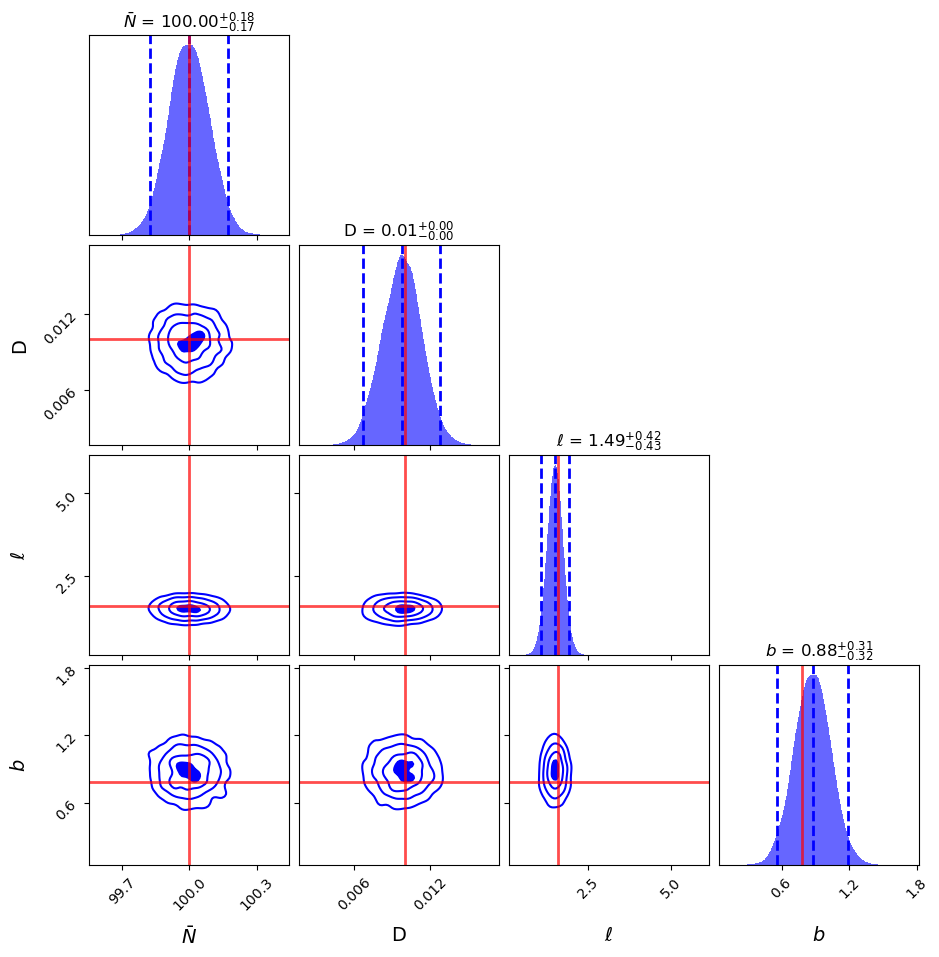

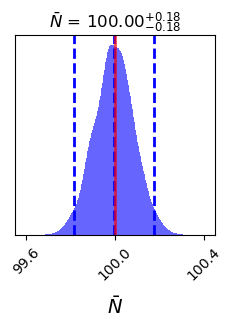

In [146]:
fig, ax = dyplot.cornerplot(results, color='blue', truths=[N_bar_true, D_true, dipole_phi, dipole_theta],
                           truth_color='r', show_titles=True,
                           max_n_ticks=3, labels=[r'$\bar N$', 'D', r'$\ell$', r'$b$'],
                           label_kwargs={'fontsize': 14})

fig, ax = dyplot.cornerplot(mono_results, color='blue', truths=[N_bar_true],
                           truth_color='r', show_titles=True,
                           max_n_ticks=3, labels=[r'$\bar N$'],
                           label_kwargs={'fontsize': 14})
# plt.savefig('../Figures/corner_plot_dipole_NSIDE_64.png', dpi=300)



In [149]:
print(results.logz[-1])
print(mono_results.logz[-1])

bayes_factor = results.logz[-1] - mono_results.logz[-1]
print(bayes_factor)

-45721.46788948933
-45734.82390644859
13.35601695926016


In [15]:
def save_params(result):
    samples = result['samples']
    weights = np.exp(result['logwt'] - np.max(result['logwt']))  # Normalize weights

    num_params = samples.shape[1]
    param_labels = [f'param_{i+1}' for i in range(num_params)]

    quantiles = [0.025, 0.5, 0.975]  # 2σ credible interval
    param_stats = {label: quantile(samples[:, i], quantiles, weights=weights) for i, label in enumerate(param_labels)}

    param_dict = {
        label: {
            'median': q50,
            'lower_uncertainty': q50 - q025,
            'upper_uncertainty': q975 - q50
        } 
        for label, (q025, q50, q975) in param_stats.items()
    }

    # Converting to a df for ease
    params_df = pd.DataFrame.from_dict(param_dict, orient='index')
    return params_df 

In [16]:
params_df = save_params(results)
params_df


,median,lower_uncertainty,upper_uncertainty
param_1,40.000136,0.055042,0.056183
param_2,0.006740,0.002528,0.002451
param_3,1.946731,0.545557,0.516536
param_4,0.808718,0.352782,0.381262


In [17]:
print(N_bar_true, D_true, dipole_phi, dipole_theta)


40 0.007 1.5707963267948966 0.7853981633974483


# Now that it's working, instead of using the values in Oliver's paper I'll try for different average densities, dipole amplitudes and directions

In [41]:
def draw_values():
    N_bar = np.random.uniform(0, 100)
    D = np.random.uniform(0, 0.1)
    dipole_phi = np.random.uniform(0, 2*np.pi)
    
    c = np.random.uniform(0,1)
    dipole_theta = np.arccos(np.clip(1 - 2*c, -1, 1))
    
    return N_bar, D, dipole_theta, dipole_phi

18.46221857185506 0.08805376195926123 1.4739718389556153 3.808061324565976


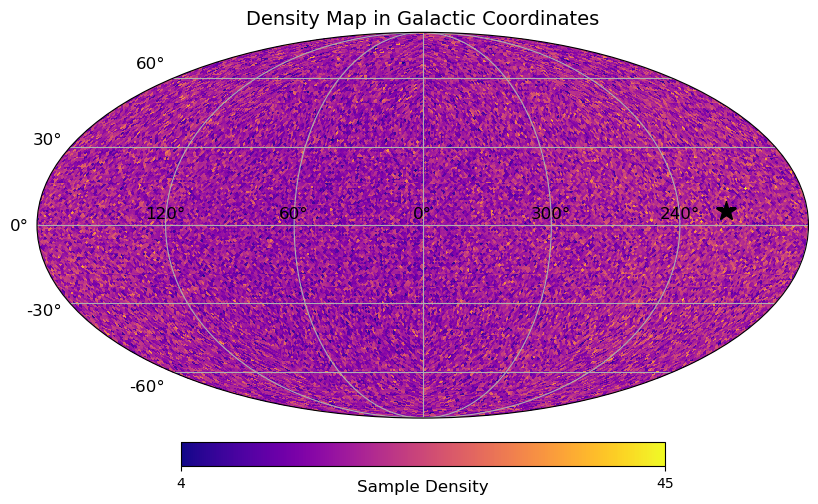

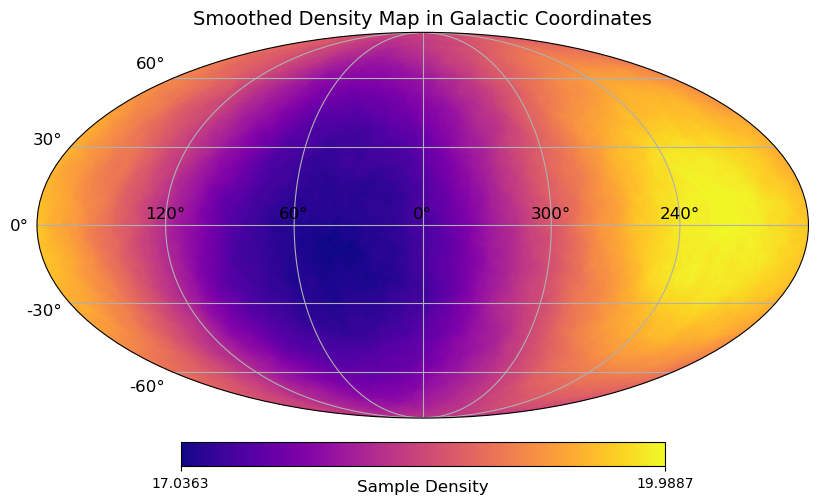

In [43]:
N_bar, D, dipole_theta, dipole_phi = draw_values()
print(N_bar, D, dipole_theta, dipole_phi)

m, lambda_true_array = poisson_sampling(NSIDE, N_bar, D, dipole_theta, dipole_phi)

if dipole_phi > np.pi:
    dipole_phi_plotting = dipole_phi - 2*np.pi
else:
    dipole_phi_plotting = dipole_phi
    
#Unsmoothed
plotting(m, dipole_theta, dipole_phi_plotting,
         title='Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

smoothed_map = compute_smooth_map(m, weights=None, angle_scale=1)

plotting(smoothed_map, dipole_theta, dipole_phi,
         title='Smoothed Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

19165it [06:08, 52.02it/s, +1000 | bound: 26 | nc: 1 | ncall: 73841 | eff(%): 27.684 | loglstar:   -inf < -141569.962 <    inf | logz: -141589.127 +/-  0.146 | dlogz:  0.001 >  1.009]


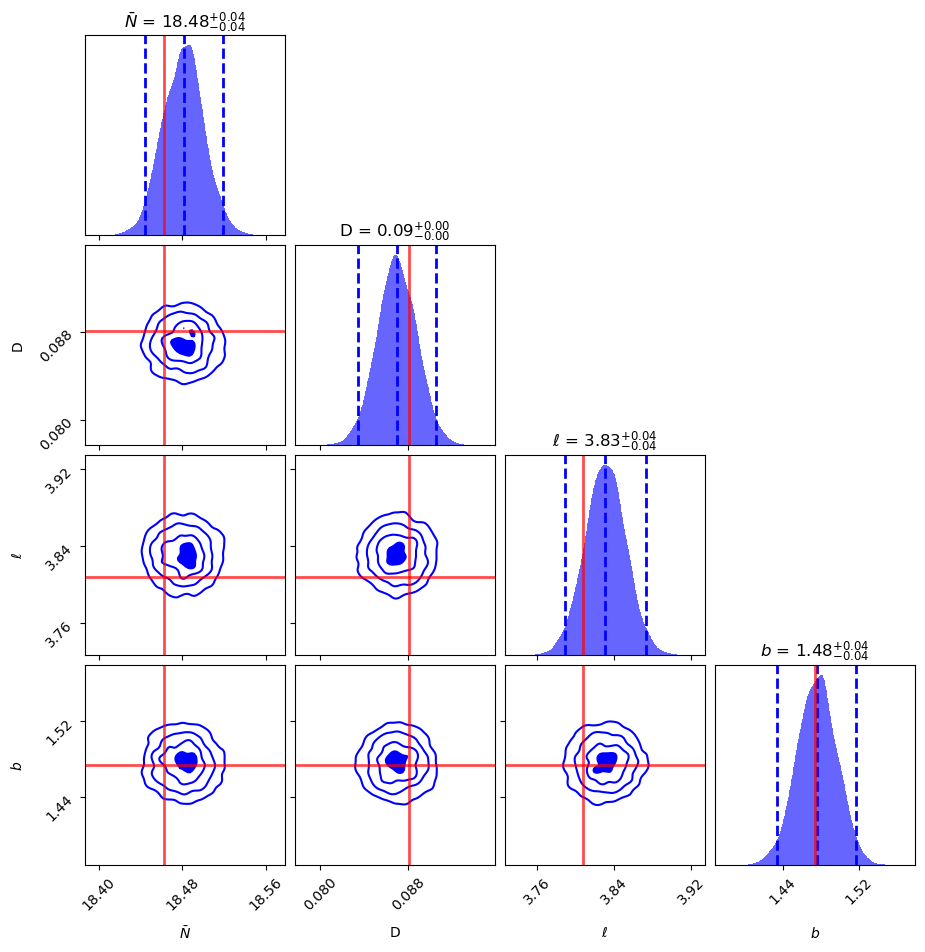

In [46]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=4, nlive=1000)
sampler.run_nested()
results = sampler.results
fig, ax = dyplot.cornerplot(results, color='blue', truths=[N_bar, D, dipole_phi, dipole_theta],
                           truth_color='red', show_titles=True,
                           max_n_ticks=3, labels=[r'$\bar N$', 'D', r'$\ell$', r'$b$'])
